# HW4 Klim Yadrintsev

## Importing

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter

import copy

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/klimyadrintsev/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
connection_string = 'sqlite:///data/data.db'

In [3]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [4]:
prices.tail(24*14)

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 01:00:00,278.65,283.80,276.36,283.44,817.668,229274.61550,COMP,ETH
2021-12-01 02:00:00,283.20,283.20,280.61,281.29,254.330,71609.32568,COMP,ETH
2021-12-01 03:00:00,281.25,283.22,279.90,283.09,393.771,110890.74168,COMP,ETH
2021-12-01 04:00:00,283.10,284.16,282.60,283.73,489.120,138532.76788,COMP,ETH
2021-12-01 05:00:00,283.84,284.46,281.95,282.57,185.039,52374.85772,COMP,ETH
...,...,...,...,...,...,...,...,...
2021-12-14 20:00:00,178.99,181.27,178.72,180.28,628.699,113081.48965,COMP,ETH
2021-12-14 21:00:00,180.15,183.76,179.96,183.43,2453.455,444711.90422,COMP,ETH
2021-12-14 22:00:00,183.31,186.74,182.60,185.24,2086.017,386571.01446,COMP,ETH


*The last entry was 2021-12-15 00:00:00 and the first 2 weeks back is 2021-12-01 01:00:00*

In [5]:
from_date = '2021-12-01'
to_date = '2021-12-15'

In [6]:
tokens = prices.groupby("token").sum().index.tolist()
tokens

['AAVE',
 'ADA',
 'ATOM',
 'AVAX',
 'BTC',
 'COMP',
 'CRV',
 'DOT',
 'ETH',
 'SOL',
 'USDT']

## Hourly return

In [7]:
def ret_h(df):
    o = df.open
    c = df.close
    result = o - c
    return result

## Hourly volatility

In [8]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

## Maxiumum drawdown upto each hour

In [9]:
def drawdown(df):
    
    o = df.open
    c = df.close
    
    result = o[0] - c
    return result.cummin()

## Colouring each day on the graph

In [10]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [11]:
token = 'BTC'
from_date = '2021-12-01'
to_date = '2021-12-15'
connection_string = 'sqlite:///data/data.db'

In [12]:
# Parameters
from_date = "2021-12-01"
to_date = "2021-12-15"
token = "AVAX"
connection_string = "sqlite:///data/data.db"


In [13]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [14]:
prices['hourly_return'] = ret_h(prices)

In [15]:
prices['volatility'] = vol_ohlc(prices)

In [16]:
prices['drawdown_max'] = abs(drawdown(prices))

In [17]:
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,hourly_return,volatility,drawdown_max
ts,,,,,,,,,,,
2021-12-01 00:00:00,120.52,122.69,120.40,121.22,58982.875,7.178868e+06,AVAX,AVAX,-0.70,NaN,0.70
2021-12-01 01:00:00,121.28,124.40,120.49,124.06,66106.301,8.146064e+06,AVAX,AVAX,-2.78,NaN,3.54
2021-12-01 02:00:00,124.07,127.18,123.88,127.09,80354.716,1.008255e+07,AVAX,AVAX,-3.02,NaN,6.57
2021-12-01 03:00:00,127.07,127.59,122.84,124.59,82091.857,1.023314e+07,AVAX,AVAX,2.48,NaN,6.57
2021-12-01 04:00:00,124.48,126.65,123.34,125.72,91628.118,1.146038e+07,AVAX,AVAX,-1.24,NaN,6.57


In [18]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

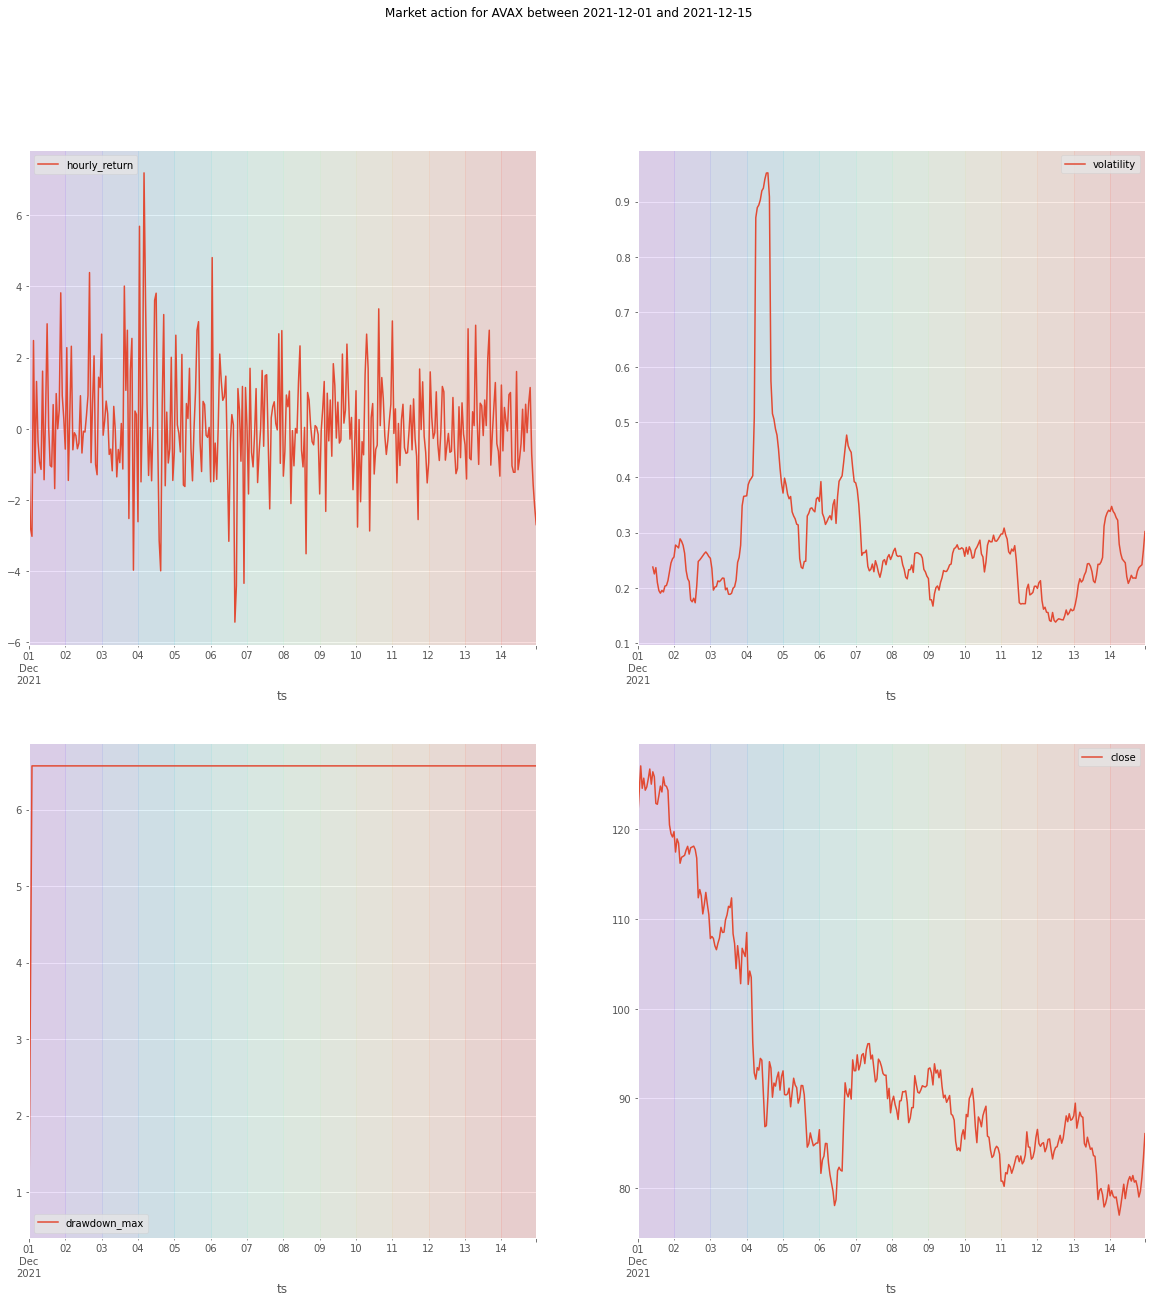

In [19]:
series_plot(prices[['hourly_return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['drawdown_max']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

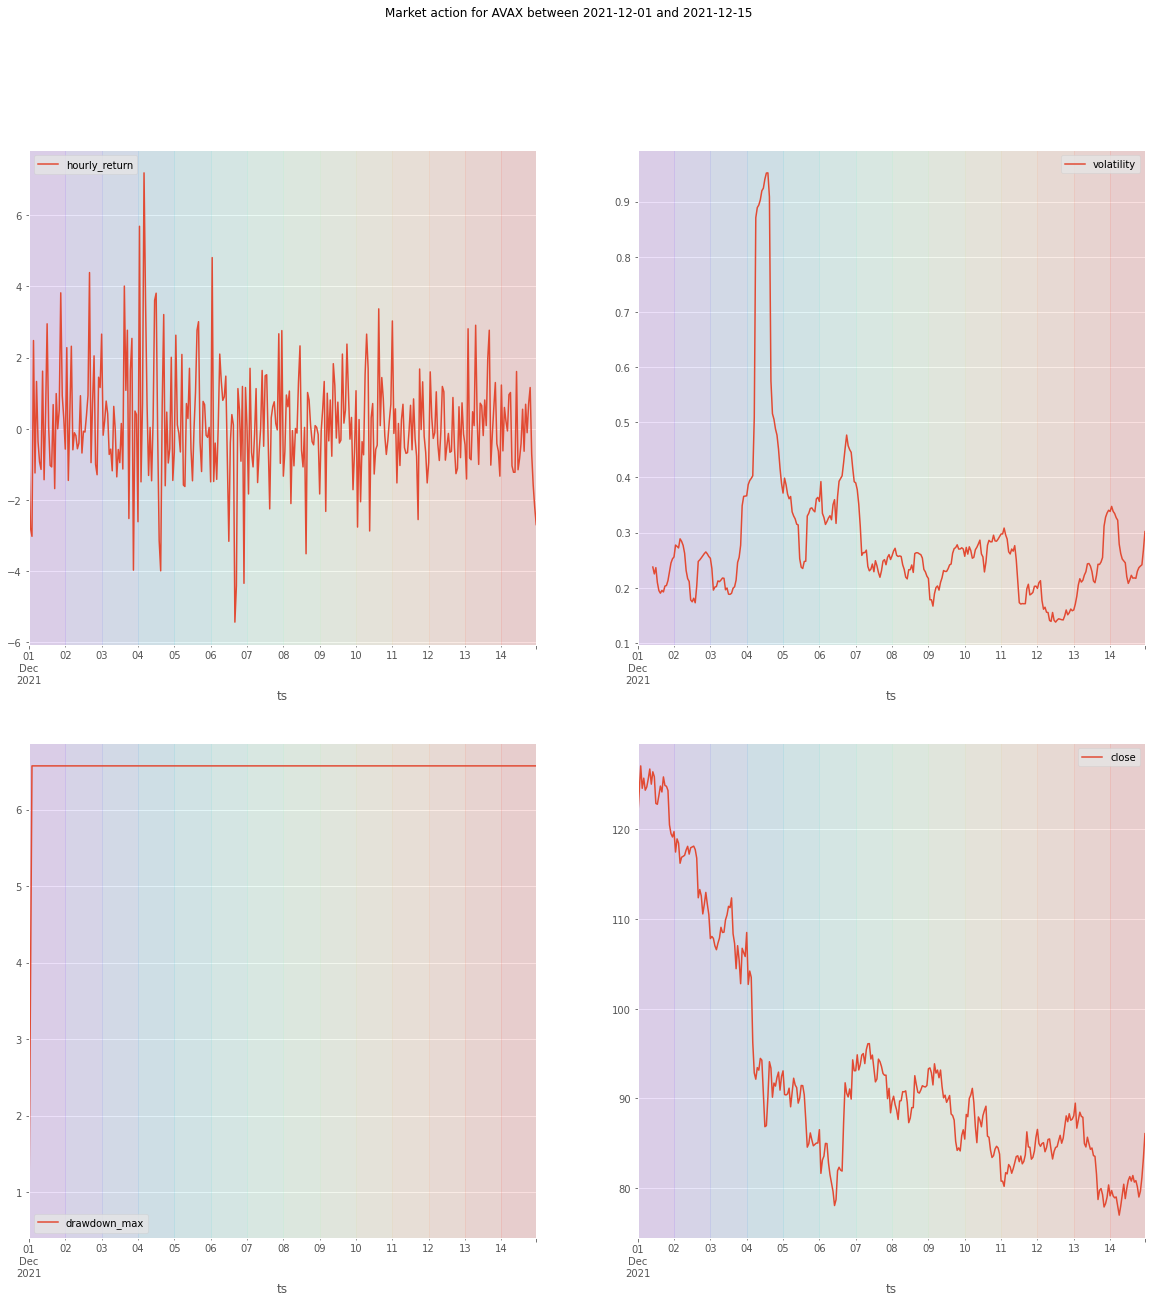

In [20]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)